**Lidar Point Classification and DEM Generation** 

**Author:** Lindsey Finks \
**Purpose:** Working with pdal to explore, visualize (via open3d), classify point clouds. Generate high quality bare earth DEM. Assignment 1 for FREC 6214.\
**Date:** Feb. 2nd, 2024


In [1]:
#import libraries
import os
import pdal #for pipelines to filter point cloud data
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
from collections import Counter

#visualizing point clouds:
import laspy #reads and writes las datasets
import open3d as o3d #for point cloud vis

# importing the module that we can call Path function
from pathlib import Path
from osgeo import gdal

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


**Tasks 1: Choosing data** 

**Point Cloud File name:** USGS_LPC_CO_SanLuisJuanMiguel_2020_D20_13S_CB_5419

Data is from USGS 3DEP lidar (https://www.usgs.gov/3d-elevation-program)

**Task 2: Exploring data**
 - Acquisition dates: 
     - 6/28/2020 - 9/6/2020
 - Projection of points: 
      - NAD 1983 UTM Zone 13N
 - Resolution: 
      - 1 meter
 - Classes present: 
     - 1 (unclassified): 1963212 points
     - 2 (ground): 3137944 points
     - 7 (noise): 4930 points
     - 18 (high noise): 4355 points
 - Returns:
     - 6
 - Intensity: 
     - Most prevalent distinguishing areas of changing elevation; less intensity at the highest point of elevation
     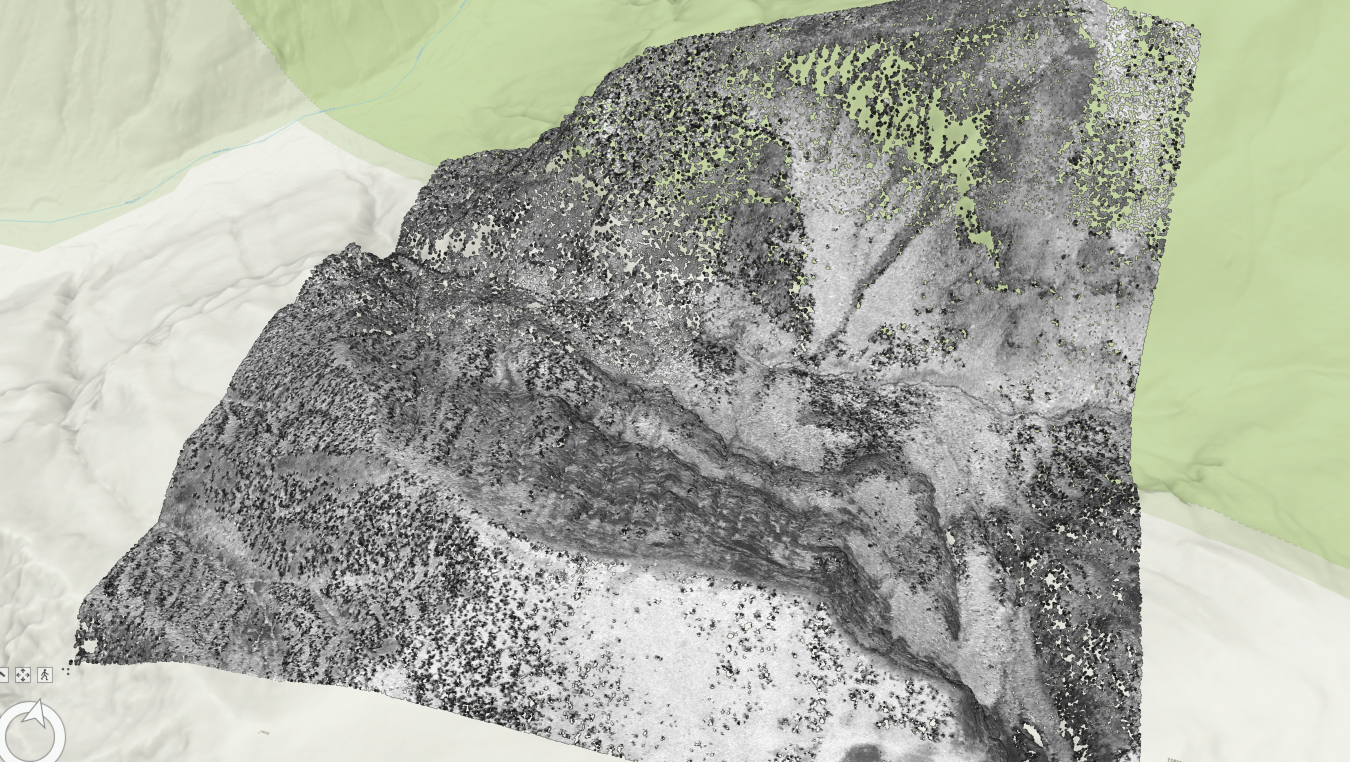
 - Range of heights/elevations:
     - Minimum elevation: 2997 ft
     - Maximum elevation: 3720 ft
 - Any obvious classification errors?
    - I can't see any obvious classification errors, but there are not many points for areas with extreme slope
 
 Points visualized in ArcGIS Pro:
 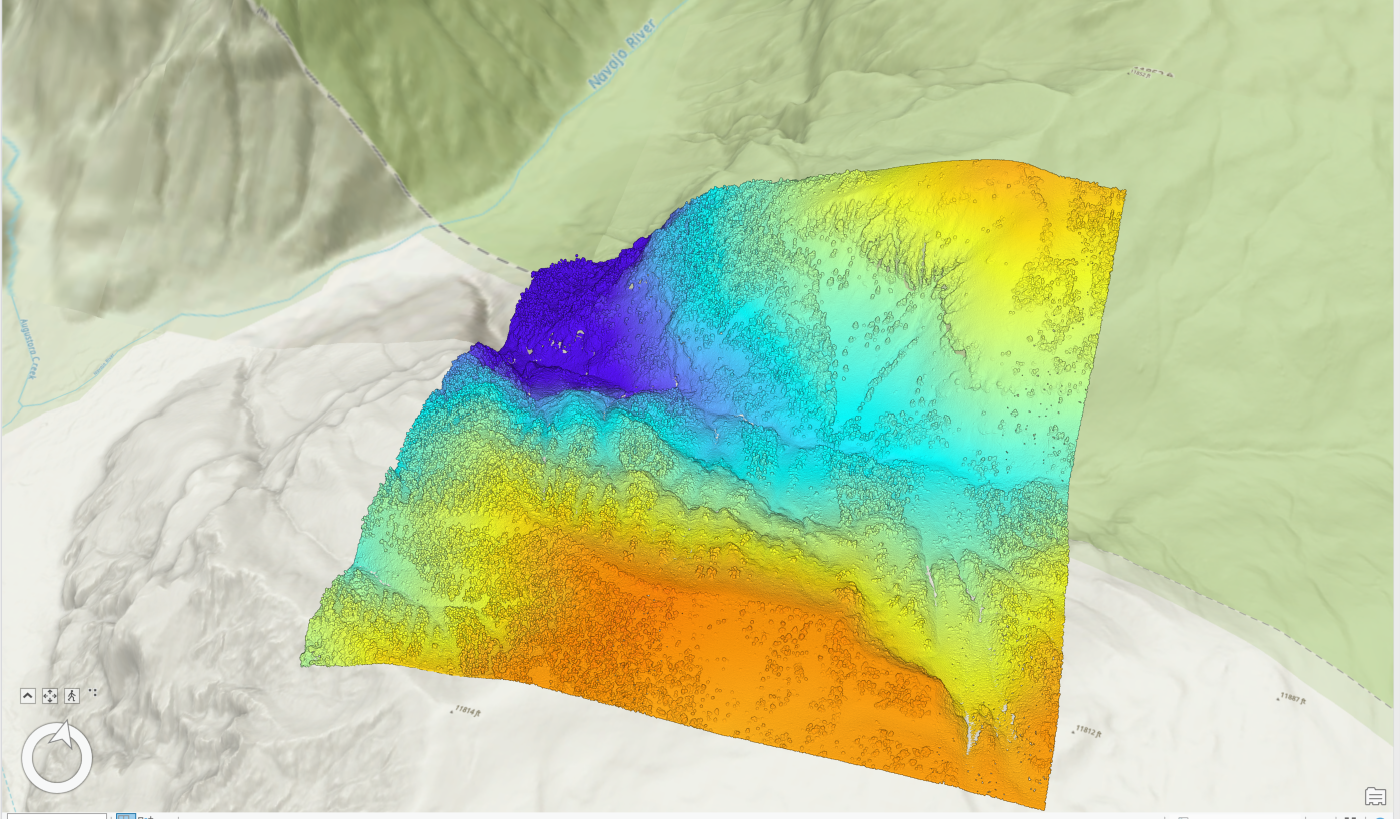


# Exploring lidar data using laspy

In [2]:
#Working with laspy to explore and visualize data
#note: laspy only likes .las files

las = laspy.read('C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/Classification_DEMGen/USGS_LPC_CO_SanLuisJuanMiguel_2020_D20_13S_CB_5419.las')

#Returns point classficiation values:
print(np.unique(las.classification))

#Returns counts of points in classes
classes = las.classification
class_count = Counter(classes)

for class_code, count in class_count.items():
    print(f"Class {class_code}: {count} points")

#Returns return numbers of data
print("Returns:", np.unique(las.return_num))

#Returns min and max elevations
print("Minimum elevation:", min(las.z))
print("Maximum elevation:", max(las.z))

[ 1  2  7 18]
Class 1: 1963212 points
Class 2: 3137944 points
Class 18: 4355 points
Class 7: 4930 points
Returns: [1 2 3 4 5 6]
Minimum elevation: 2997.131
Maximum elevation: 3720.637


# Visualizing Point Clouds with laspy and open3d

open3d output showing point cloud and noise:
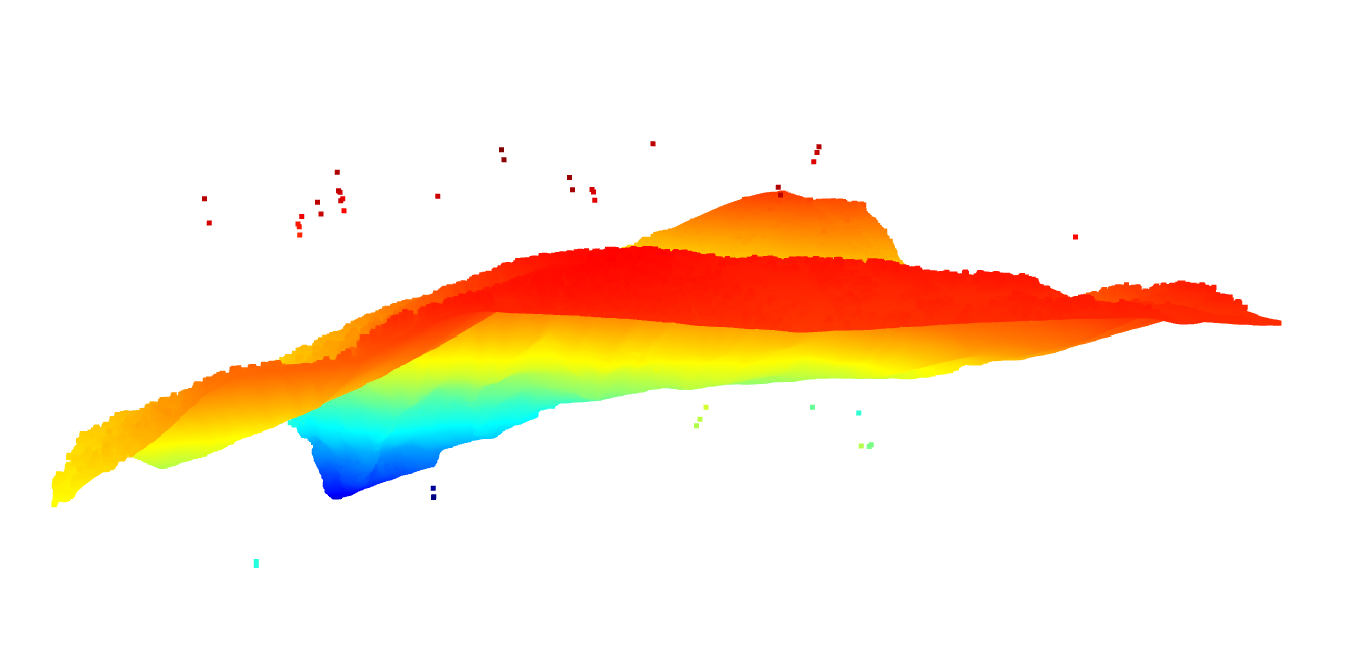

In [3]:
#To visualize in o3d, assign x,y,z values
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1,0))

geom = o3d.geometry.PointCloud()

geom.points = o3d.utility.Vector3dVector(point_data)

o3d.visualization.draw_geometries([geom])

# Point Classification and DEM generation

**PDAL Pipelines**\
Pipelines define the processing of data (similar to a workflow). They give record of the operations applied to the data:\
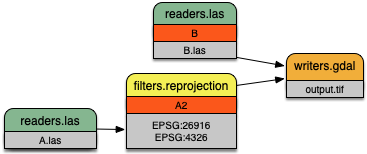

Info on pipelines: https://pdal.io/en/2.6.0/pipeline.html \
Info on filters: https://pdal.io/en/2.6.0/stages/filters.html

In [5]:
#set file path
lidarfile = 'C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/Classification_DEMGen/USGS_LPC_CO_SanLuisJuanMiguel_2020_D20_13S_CB_5419.las'

In [6]:
#super simple pipeline to look at file metadata
pipeline = [
    {
        "type":"readers.las", #filters start with 'type':
        "filename": lidarfile
    },
]

pipeline = pdal.Pipeline(json.dumps(pipeline))
pipeline.execute()

5110441

In [7]:
pipeline.schema #info on data that exists

{'schema': {'dimensions': [{'name': 'X', 'size': 8, 'type': 'floating'},
   {'name': 'Y', 'size': 8, 'type': 'floating'},
   {'name': 'Z', 'size': 8, 'type': 'floating'},
   {'name': 'Intensity', 'size': 2, 'type': 'unsigned'},
   {'name': 'ReturnNumber', 'size': 1, 'type': 'unsigned'},
   {'name': 'NumberOfReturns', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanDirectionFlag', 'size': 1, 'type': 'unsigned'},
   {'name': 'EdgeOfFlightLine', 'size': 1, 'type': 'unsigned'},
   {'name': 'Classification', 'size': 1, 'type': 'unsigned'},
   {'name': 'Synthetic', 'size': 1, 'type': 'unsigned'},
   {'name': 'KeyPoint', 'size': 1, 'type': 'unsigned'},
   {'name': 'Withheld', 'size': 1, 'type': 'unsigned'},
   {'name': 'Overlap', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanAngleRank', 'size': 4, 'type': 'floating'},
   {'name': 'UserData', 'size': 1, 'type': 'unsigned'},
   {'name': 'PointSourceId', 'size': 2, 'type': 'unsigned'},
   {'name': 'GpsTime', 'size': 8, 'type': 'floating'},
 

In [8]:
pipeline.metadata #metadata

{'metadata': {'filters.merge': {},
  'readers.las': {'comp_spatialreference': 'COMPD_CS["NAD83(2011) / UTM zone 13N + NAVD88 height - US Geoid Model of 2018",PROJCS["NAD83(2011) / UTM zone 13N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["Degree",0.0174532925199433,AUTHORITY["EPSG","9102"]],AXIS["Geodetic longitude",EAST],AXIS["Geodetic latitude",NORTH],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["central_meridian",-105],PARAMETER["latitude_of_origin",0],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6342"]],VERT_CS["NAVD88 height - US Geoid Model of 2018",VERT_DATUM["North American Vertical Datum 1988",2005,AUTHORITY["EPSG","5103"]],U

# Ground Classification and writing out new las file

In [9]:
pipeline = [
    {
        "type": "readers.las",
        "filename": lidarfile
    },
    {
        "type":"filters.assign",
        #classifying points to 0
        "assignment":"Classification[:]=0"
    },
    {
        #filter out low noise points, extended local minimum
        "type":"filters.elm"
    },
    {
         #filter out noise or outliers   
        "type":"filters.outlier"
    },
    {
        "type":"filters.smrf",
        "ignore":"Classification[7:7]",
        #default slope is 0.15
        "slope":0.2,
        #window in linear units
        "window":16,
        "threshold":0.45,
        "scalar":1.2
    },
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    },
       {
        "type":"writers.las",
        "filename":"C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/SLJM_ground.las"
    }
        
  ]

pipeline = pdal.Pipeline(json.dumps(pipeline))
pipeline.execute()

3845741

Visualize ground points:
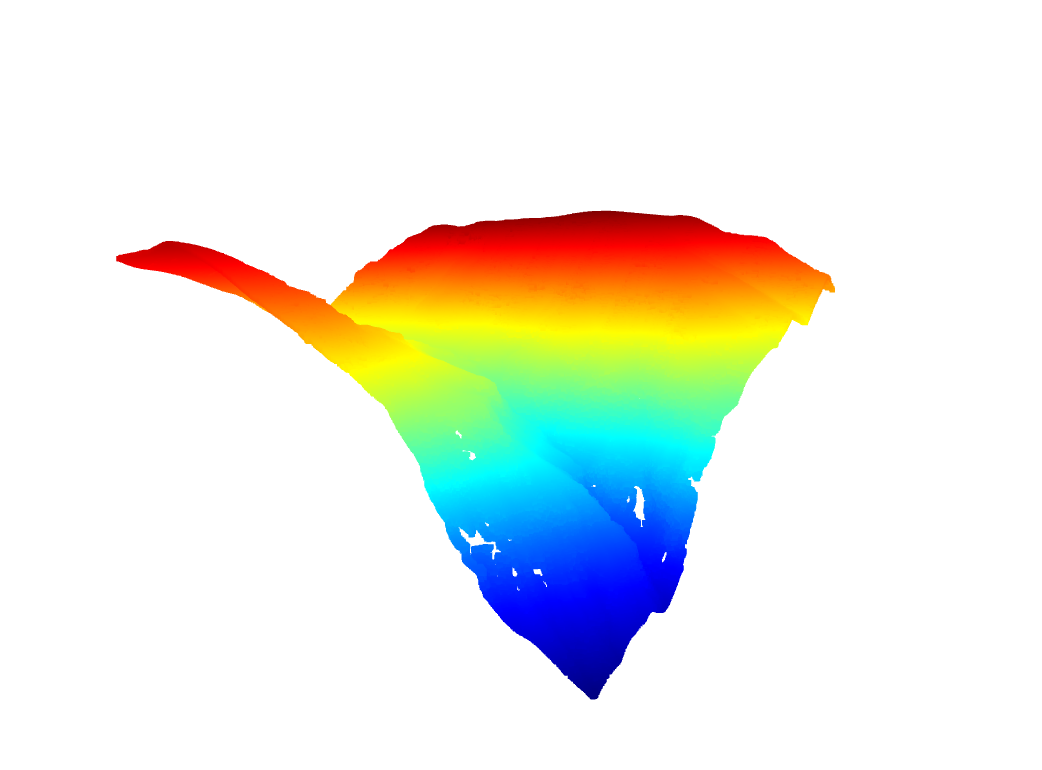

In [10]:
ground_las = laspy.read('C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/SLJM_ground.las')

point_data = np.stack([ground_las.X, ground_las.Y, ground_las.Z], axis=0).transpose((1,0))

geom = o3d.geometry.PointCloud()

geom.points = o3d.utility.Vector3dVector(point_data)

o3d.visualization.draw_geometries([geom])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


# Creating High Resolution DEM

I'm using the Simple Morphological Filter (SMRF) and Inverse Distance Weighting (IDW) for DEM creation. Due to the severe elevation changes, the IDW approach led to gaps in my output DEM (seen below). 

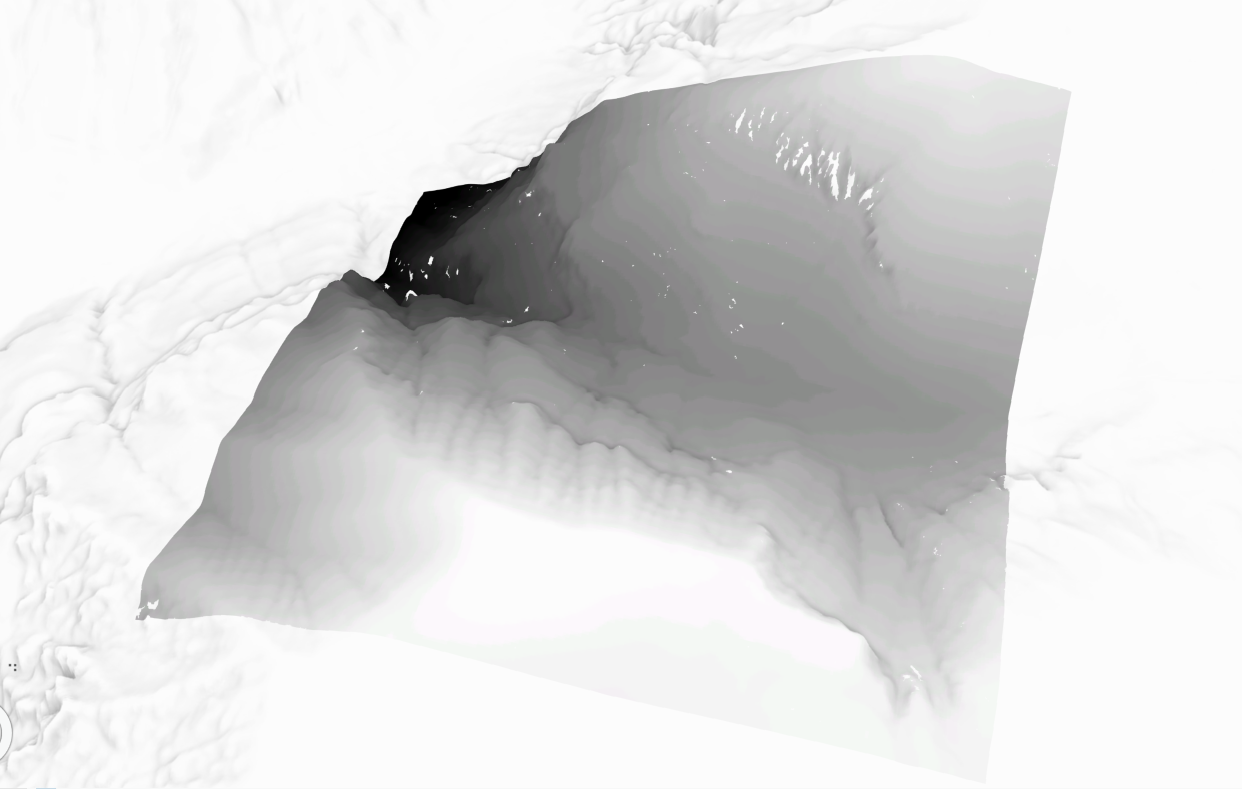

In [42]:
pipeline = [
    {
        "type": "readers.las",
        "filename": lidarfile
    },
    {
        "type":"filters.reprojection",
        "out_srs":"EPSG:26913"
    },
    {
        "type":"filters.assign",
        #classifying points to 0
        "assignment":"Classification[:]=0"
    },
    {
        #filter out low noise points, extended local minimum
        "type":"filters.elm"
    },
    {
        "type":"filters.outlier"
    },
    {
        #uses nearest neighbor approach to fill voids, using default values for slope, window, threshold, scalar
        "type":"filters.smrf",
        "ignore":"Classification[7:7]",
        "slope":0.2, 
        "window":16,
        "threshold":0.45,
        "scalar":1.2
    },
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    },
       {
        "type":"writers.gdal",
        "filename":"C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/Classification_DEMGen/SLJM_DEM.tif",
           "gdaldriver": "GTiff",
           "output_type":"idw",
           "resolution":"1.0",
           "radius":"2",
           "data_type":"float32"
    }
        
  ]

pipeline = pdal.Pipeline(json.dumps(pipeline))
pipeline.execute()

3845843

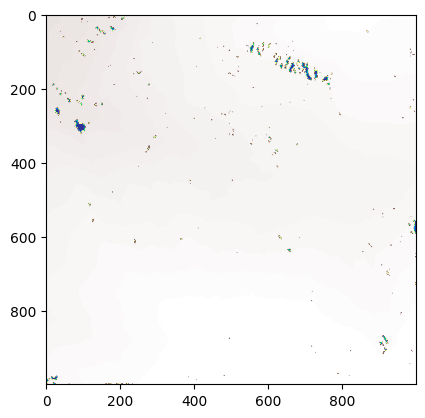

<Axes: >

In [41]:
import rasterio as rio
from rasterio.plot import show

#Open DEM file created in last step
dem = 'C:/Users/lfink/Desktop/Spring 24 classes/Forestry Lidar Applications/Classification_DEMGen/SLJM_DEM.tif'

with rio.open(dem) as src:
    dem = src.read(1)
    
#Plot
show(dem, cmap = 'terrain')